### Data

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

There are 10 real-valued features: radius, texture, perimeter, area, smoothness, concavity, concave points, symmetry and fractal dimension.

The mean, standard error and worst of each of the features is given in the data.

Each row has an ID number and a diagnosis (M for malignant or B for benign).

In [102]:
import pandas as pd

data = pd.read_csv("data.csv")

# All values in this column were NaN
data.drop("Unnamed: 32", axis=1, inplace=True)

data["diagnosis"] = data["diagnosis"].map({"M":1, "B":0})

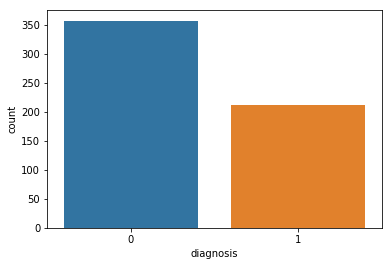

In [103]:
import seaborn as sns

sns.countplot(data["diagnosis"], label="count")

### Feature Selection

Note: use P-value in the future: https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf

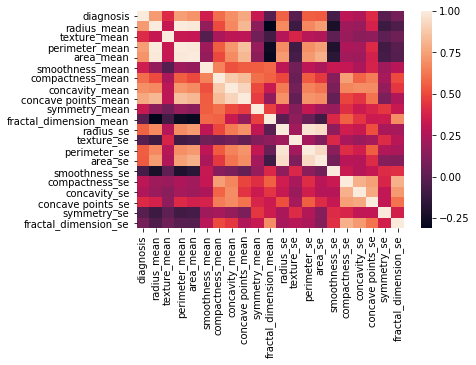

In [104]:
mean_of_features = list(data.columns[2:12])
se_of_features = list(data.columns[12:22])
worst_of_features = list(data.columns[22:32])

data = data.drop("id", axis=1)
# mean and worst are obviously correlated anyway
features_data = data.drop(worst_of_features, axis=1)
corr = features_data.corr()
sns.heatmap(corr)

In [105]:
for i in range(corr.shape[0]):
    for j in range(i):
        if corr.iloc[i, j] >= 0.9:
            print(corr.index[i] + "    " + corr.index[j])

perimeter_mean    radius_mean
area_mean    radius_mean
area_mean    perimeter_mean
concave points_mean    concavity_mean
perimeter_se    radius_se
area_se    radius_se
area_se    perimeter_se


Perimeter mean, radius mean and area mean are all correlated.<br>
Concave points mean is correlated to concavity mean.<br>
Perimeter standard error, radius standard error and area standard error are all correlated.<br>
Therefore, we can use only the area, removing the perimeter and radius. We can also remove the concave points mean and use only the concavity mean. We will also ignore standard error entirely for now for simplicity.

In [106]:
prediction_features = ["texture_mean", "area_mean", "smoothness_mean", "compactness_mean", "concavity_mean", "symmetry_mean", 
                       "fractal_dimension_mean"]

In [107]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.1)

In [108]:
# training data
x_train = train[prediction_features]
y_train = train.diagnosis

# test data
x_test = test[prediction_features]
y_test = test.diagnosis

### Model

Note: experiment with different models

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model = RandomForestClassifier(n_estimators=100)

In [110]:
# training
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [111]:
prediction = model.predict(x_test)

In [112]:
metrics.accuracy_score(y_test, prediction)

0.9122807017543859

In [113]:
feature_importance = pd.Series(model.feature_importances_, index=prediction_features).sort_values(ascending=False)

feature_importance

area_mean                 0.322649
concavity_mean            0.264360
compactness_mean          0.147469
texture_mean              0.097643
smoothness_mean           0.068192
fractal_dimension_mean    0.056046
symmetry_mean             0.043642
dtype: float64

In [114]:
# Let's only take top 5 most important features
prediction_features = ["concavity_mean", "area_mean", "compactness_mean", "texture_mean", "smoothness_mean"]

In [115]:
x_train = train[prediction_features]
y_train = train.diagnosis

x_test = test[prediction_features]
y_test = test.diagnosis

In [116]:
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [117]:
prediction = model.predict(x_test)

In [118]:
metrics.accuracy_score(y_test, prediction)

0.9649122807017544

### K-Fold cross-validation

In [128]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=2)

cv_data = data[prediction_features]
cv_diagnosis = data.diagnosis

"""
for train_index, test_index in kf.split(cv_data):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = cv_data[train_index], cv_data[test_index]
    y_train, y_test = cv_diagnosis[train_index], cv_diagnosis[test_index]
"""

TRAIN: [285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302
 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320
 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338
 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356
 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374
 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392
 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410
 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428
 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500
 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518
 519 520 521 522 523 524 525 526 527 528 529

KeyError: '[285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302\n 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320\n 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338\n 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356\n 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374\n 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392\n 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410\n 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428\n 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446\n 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464\n 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482\n 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500\n 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518\n 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536\n 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554\n 555 556 557 558 559 560 561 562 563 564 565 566 567 568] not in index'